In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib


In [3]:
df = pd.read_csv(r"C:\Users\ttcbl\Downloads\housing new (2).csv")
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)
df = pd.get_dummies(df, columns=['ocean_proximity'])
df.head()


C:\Users\ttcbl\AppData\Local\Temp\ipykernel_23816\2941412444.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False


In [7]:
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (16512, 13)
Test size: (4128, 13)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }

pd.DataFrame(results).T


,MAE,RMSE,R2
Linear Regression,50670.738241,70060.521845,0.625424
Random Forest,31628.592391,48941.954703,0.817209


In [15]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_preds = best_rf.predict(X_test)

print("Tuned RF Performance:")
print("MAE:", mean_absolute_error(y_test, best_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, best_preds)))
print("R2:", r2_score(y_test, best_preds))


Tuned RF Performance:
MAE: 31464.93347383721
RMSE: 48781.55875664814
R2: 0.818404748880555


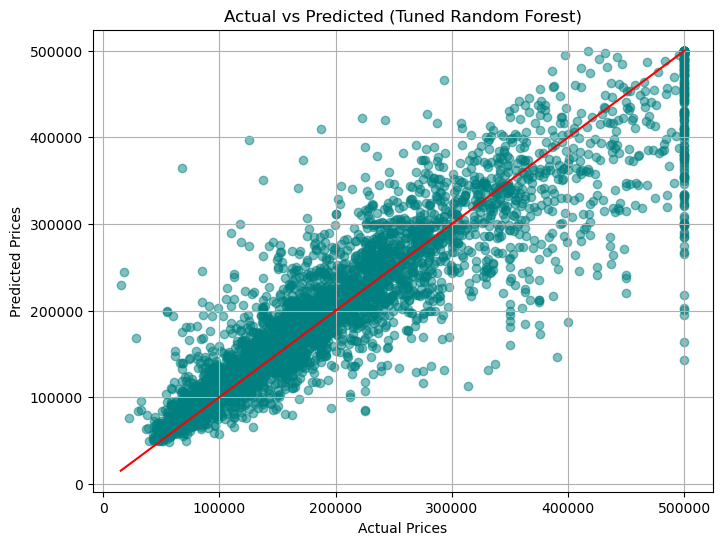

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_preds, alpha=0.5, color='teal')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted (Tuned Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.grid(True)
plt.show()


In [21]:
joblib.dump(best_rf, "best_random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [23]:
import joblib

joblib.dump(models["Random Forest"], "best_random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

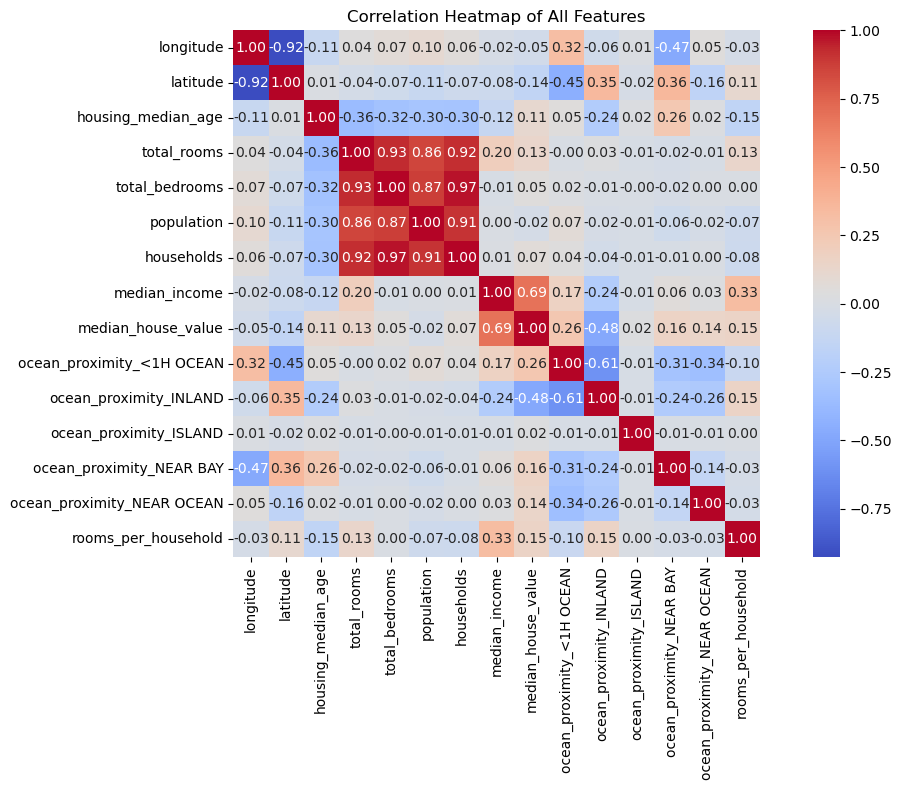

In [38]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of All Features")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)  # Save as PNG
plt.show()


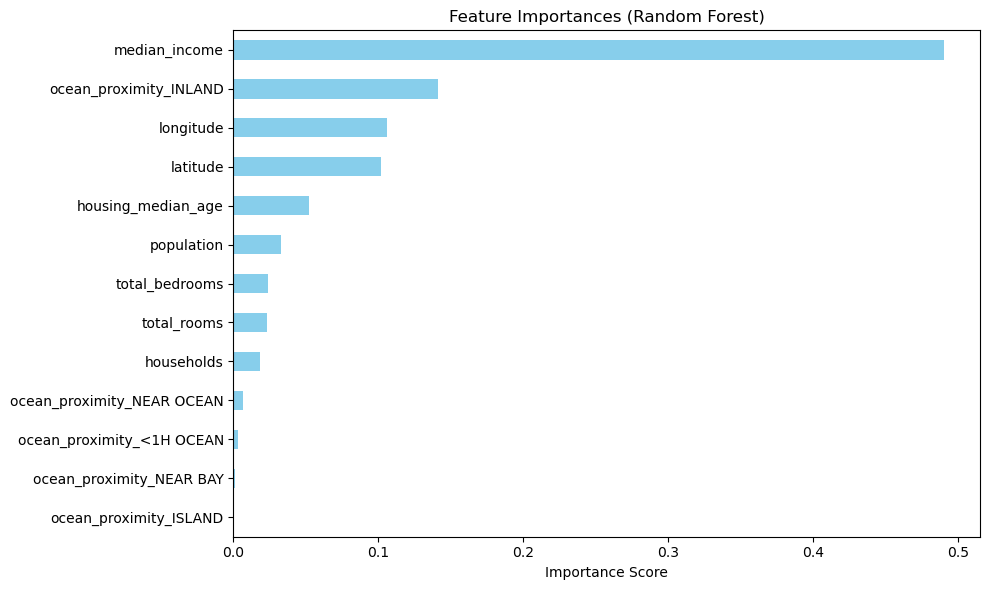

In [40]:

importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importances.png", dpi=300)
plt.show()


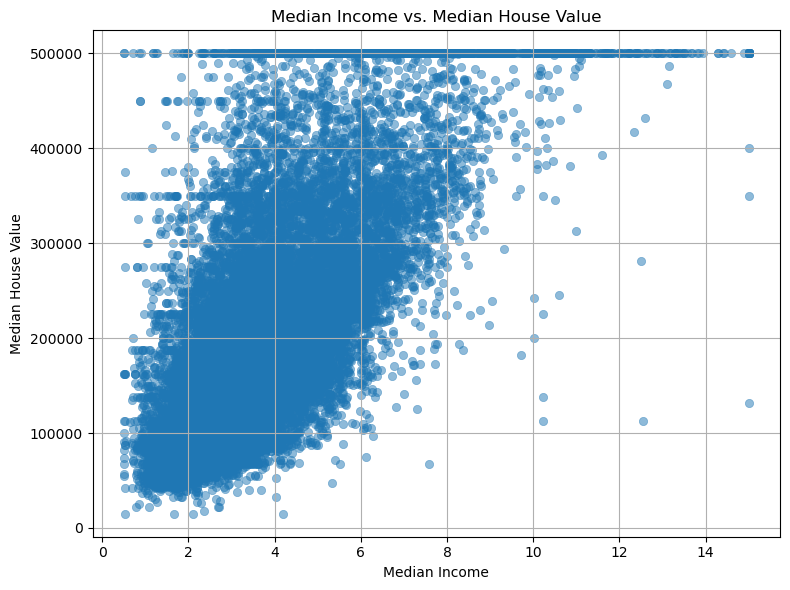

In [42]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="median_income", y="median_house_value", alpha=0.5, edgecolor=None)
plt.title("Median Income vs. Median House Value")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.grid(True)
plt.tight_layout()
plt.savefig("income_vs_price.png", dpi=300)
plt.show()


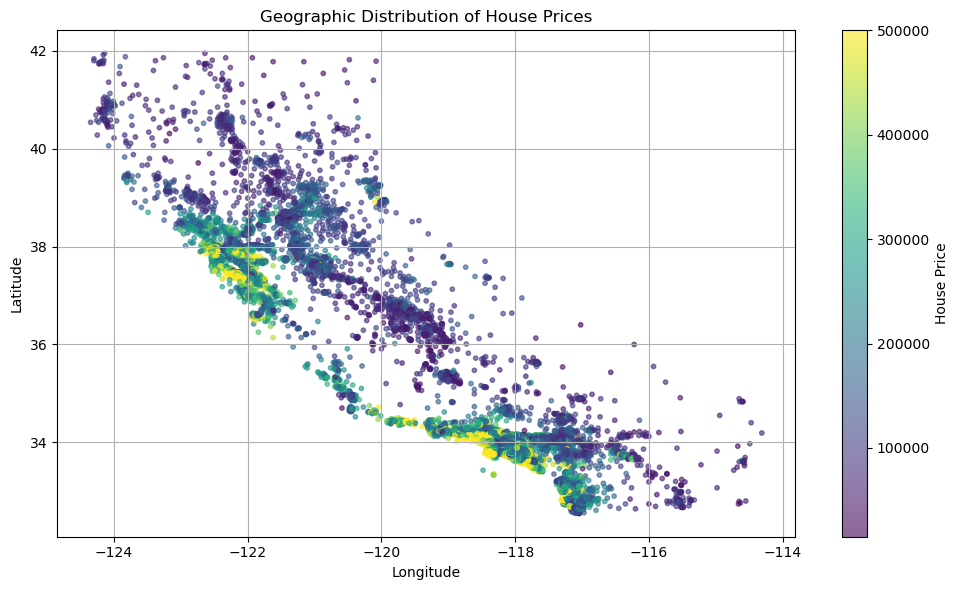

In [44]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["longitude"], df["latitude"], 
    c=df["median_house_value"], cmap="viridis", 
    s=10, alpha=0.6
)
plt.colorbar(scatter, label="House Price")
plt.title("Geographic Distribution of House Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("geo_price_distribution.png", dpi=300)
plt.show()


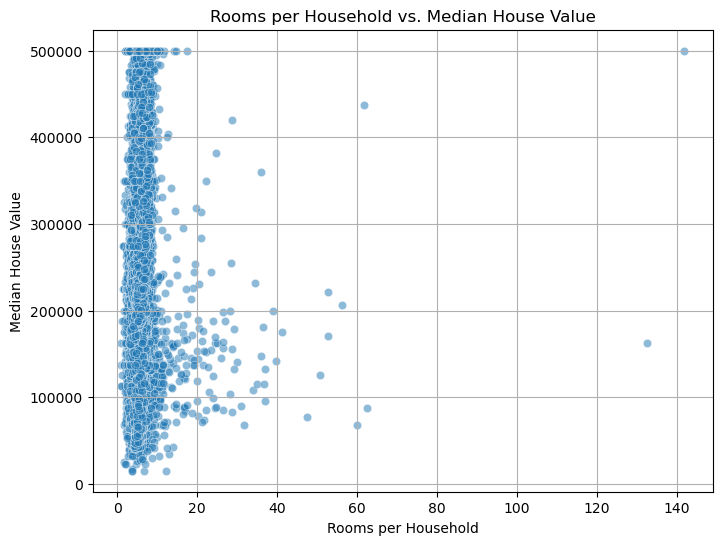

In [48]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="rooms_per_household", y="median_house_value", alpha=0.5)
plt.title("Rooms per Household vs. Median House Value")
plt.xlabel("Rooms per Household")
plt.ylabel("Median House Value")
plt.grid(True)
plt.savefig("rooms_perh_median.png", dpi=300)
plt.show()



In [50]:
df.to_csv("cleaned_housing_data.csv", index=False)
